In [1]:
import xgboost as xgb
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/Users/suicideboy/Desktop/Python Projects/Datasets/UCI_Credit_Card.csv')
df.head()
# I am going to use XGBoost to predict whether someone will default on their credit card payment
# please view 'https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset' for explanation of the dataset  

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# according to the dataset description on kaggle, 0, 4, 5 and 6 are unknown so I wish to drop these rows
df.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0])

In [4]:
df.drop(df[(df['EDUCATION'] == 0) | (df['EDUCATION'] == 4) | (df['EDUCATION'] == 5)| (df['EDUCATION'] == 6)].index, axis = 0, inplace = True)

In [5]:
# we now have our desired unique values 
df.EDUCATION.unique()

array([2, 1, 3])

In [6]:
df.isna().sum()
# checking for empty values 

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [7]:
cols = ['AGE', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month']
df1 = df[cols]
# these are the features that I believe will have the greatest impact on the chance of defaulting

In [8]:
# we must use one-hot encoding for education which is non-ordinal categorical data 
encoded_df = pd.get_dummies(df1, columns = ['EDUCATION'])
encoded_df

,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month,EDUCATION_1,EDUCATION_2,EDUCATION_3
0,24,2,2,-1,-1,-2,-2,1,0,1,0
1,26,-1,2,0,0,0,2,1,0,1,0
2,34,0,0,0,0,0,0,0,0,1,0
3,37,0,0,0,0,0,0,0,0,1,0
4,57,-1,0,-1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
29995,39,0,0,0,0,0,0,0,0,0,1
29996,43,-1,-1,-1,-1,0,0,0,0,0,1
29997,37,4,3,2,-1,0,0,1,0,1,0
29998,41,1,-1,0,0,0,-1,1,0,0,1


In [9]:
X = encoded_df.drop('default.payment.next.month', axis = 1)
y = encoded_df['default.payment.next.month']

In [10]:
X

,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,EDUCATION_1,EDUCATION_2,EDUCATION_3
0,24,2,2,-1,-1,-2,-2,0,1,0
1,26,-1,2,0,0,0,2,0,1,0
2,34,0,0,0,0,0,0,0,1,0
3,37,0,0,0,0,0,0,0,1,0
4,57,-1,0,-1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
29995,39,0,0,0,0,0,0,0,0,1
29996,43,-1,-1,-1,-1,0,0,0,0,1
29997,37,4,3,2,-1,0,0,0,1,0
29998,41,1,-1,0,0,0,-1,0,0,1


In [11]:
# stratifying our data so we get the same proportion of individuals who default in the test and training subsets 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 28, stratify = y)

In [12]:
model = xgb.XGBClassifier(objective = 'binary:logistic', seed = 28, max_depth = 20)
model.fit(X_train, Y_train, verbose = True)
# the model can be tuned to increase our model score but this can also come at a cost of overfitting

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=28, ...)

In [13]:
model.score(X_train, Y_train)

0.8887195767195767

In [14]:
Y_pred = model.predict(X_test)

In [15]:
# splitting the data into 10 parts for k-fold cross validation 
# this helps us get a good idea of whether the model is accurate 
kfold = StratifiedKFold(n_splits = 10)
score2 = cross_val_score(model, X, y, cv = kfold)
score2

array([0.78063643, 0.78977657, 0.7907213 , 0.78394853, 0.79038266,
       0.79139858, 0.80494412, 0.80765323, 0.80325093, 0.78970538])

In [16]:
# average of the cross validation scores 
score2.mean()

0.7932417740264368

In [17]:
# to assess whether our predicted values were predicted correctly
confusion_matrix(Y_test, Y_pred)

array([[4212,  374],
       [ 831,  490]])

In [18]:
Postgraduates = df[df['EDUCATION'] == 1]['default.payment.next.month'].value_counts()
Graduates = df[df['EDUCATION'] == 2]['default.payment.next.month'].value_counts()
High_School = df[df['EDUCATION'] == 3]['default.payment.next.month'].value_counts()

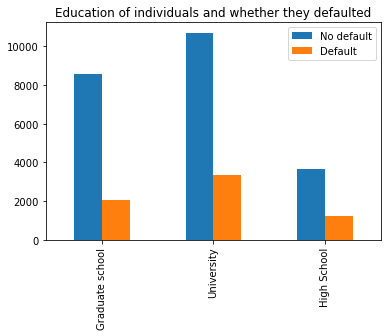

In [19]:
Education1  = pd.DataFrame([Postgraduates, Graduates, High_School])
Education1.index = ['Graduate school', 'University', 'High School']
Education1.plot(kind = 'bar')
plt.legend(["No default", "Default"])
plt.title('Education of individuals and whether they defaulted')
plt.show()

In [20]:
# getting the sum of individuals who made all previous 6 payments on time
on_time = df1[(df1['PAY_0'] == 0) & (df1['PAY_2'] == 0) & (df1['PAY_3'] == 0) & (df1['PAY_4'] == 0) & (df1['PAY_5'] == 0) & (df1['PAY_6'] == 0)]['default.payment.next.month'].value_counts()

In [21]:
on_time

0    8614
1    1013
Name: default.payment.next.month, dtype: int64

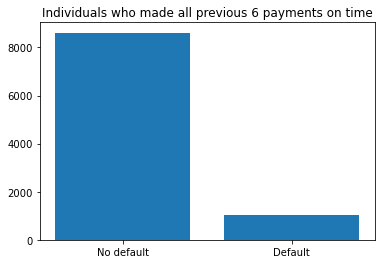

In [22]:
plt.bar(height = on_time, x = ['No default', 'Default'])
plt.title('Individuals who made all previous 6 payments on time')
plt.show()
# this shows that people who made all of the last 6 credit payments on time were highly likely to not default on their payment the following month
# this serves to show how important credit history is for lenders and banks 